# Optical Channel with Lumped Amplification

In this notebook, you will learn how to simulate the transmission of a single Gaussian impulse over a
lumped amplification channel model consisting of multiple fiber spans and optical amplifiers, so-called Erbium Doped Fiber Amplifiers (EDFA), as shown in the Figure below. We assume a *standard single mode fiber* (S-SMF) and denote the fiber length between two amplifiers by $\ell_\text{span}$.

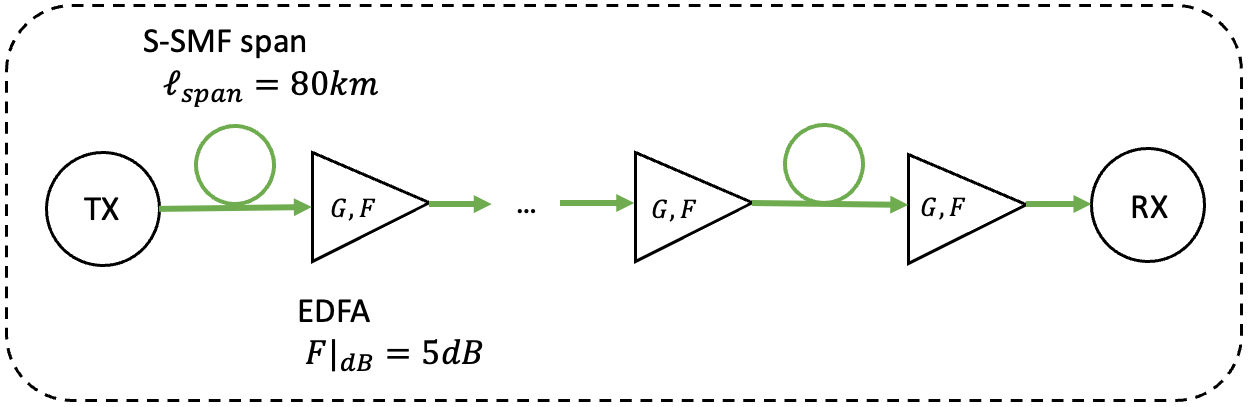

Let $G$ denote the amplifier gain and $F$ the noise figure of each EDFA.

As we focus on the optical channel and not the corresponding signal processing, 
the transmitter directly generates the optical signal. Hence, all
components that, in practice, are required to
generate the optical signal given an electrical control voltage
(e.g., the Mach-Zehnder-Modulator (MZM)) are assumed to be ideal or are neglected. The same holds on the receiver side, where the photodiode that would add shot noise is neglected.

To provide a better understanding of the implemented channel impairments (attenuation, noise, dispersion,
nonlinearity) introduced during propagation, those are successively
enabled, starting with attenuation.

## Table of Contents
- [Setup](#Setup)
- [Attenuation](#Attenuation)
- [Amplified Spontaneous Emission Noise](#Amplified-Spontaneous-Emission-Noise)
- [Chromatic Dispersion](#Chromatic-Dispersion)
- [Kerr Nonlinearity](#Kerr-Nonlinearity)
- [Split-Step Fourier Method](#Split-Step-Fourier-Method)
- [References](#References)

## Setup

In [1]:
import os
if os.getenv("CUDA_VISIBLE_DEVICES") is None:
    gpu_num = 0 # Use "" to use the CPU
    os.environ["CUDA_VISIBLE_DEVICES"] = f"{gpu_num}"
os.environ['TF_CPP_MIN_LOG_LEVEL'] = '3'

# Import Sionna
try:
    import sionna.phy
except ImportError as e:
    import sys
    if 'google.colab' in sys.modules:
       # Install Sionna in Google Colab
       print("Installing Sionna and restarting the runtime. Please run the cell again.")
       os.system("pip install sionna")
       os.kill(os.getpid(), 5)
    else:
       raise e

import tensorflow as tf
# Configure the notebook to use only a single GPU and allocate only as much memory as needed
# For more details, see https://www.tensorflow.org/guide/gpu
gpus = tf.config.list_physical_devices('GPU')
if gpus:
    try:
        tf.config.experimental.set_memory_growth(gpus[0], True)
    except RuntimeError as e:
        print(e)
# Avoid warnings from TensorFlow
tf.get_logger().setLevel('ERROR')

import numpy as np
%matplotlib inline
import matplotlib.pyplot as plt

# Set random seed for reproducibility
from sionna.phy import dtypes, config
from sionna.phy.channel import utils
config.seed = 42

## Impulse Generation

Before diving into the first channel model, the simulation shall be parametrized and the
initial Gaussian impulse

$$g(t)=\sqrt{P_0\cdot 2^{\left(-\left(\frac{2t}{T_0}\right)^2\right)}}$$

is generated. The impulse shall have peak power $P_0$ and a pulse duration of $T_0$.
Note that the Gaussian filter is infinitely long, such that $T_0$ is the
full width at half-maximum (FWHM) pulse duration.

Further, the simulation window is set to $T_\mathrm{sim}=1000\,\mathrm{ps}$ and the sample duration
is set to $\Delta_t=1\,\mathrm{ps}$.

In [2]:
config.precision="double"
config.tf_cdtype

tf.complex128

In [3]:
# Simulation parameters
config.precision = "double"
t_sim = int(1e4)  # (ps) Simulation time window
n_sim = int(1e4)  # Number of simulation samples

# Channel parameters
n_span = 3

# Impulse parameters
p_0 = 3e-2  # (W) Peak power of the Gaussian pulse
t_0 = 50  # (ps) Norm. temporal scaling of the Gaussian pulse

# Support
dt = t_sim / n_sim  # (s) sample duration
t, f = utils.time_frequency_vector(n_sim, dt)  # (ps), (THz) Time and frequency vector

# Generate Gaussian impulse
g_0 = np.sqrt(p_0 * 2**(-((2.0*t / t_0) ** 2.0)))
g_0 = tf.cast(g_0, dtype=config.tf_cdtype)
G_0 = tf.signal.fftshift(
        tf.abs(
            tf.cast(dt, config.tf_cdtype) *
            tf.signal.fft(g_0) /
            tf.cast(tf.math.sqrt(2 * np.pi), config.tf_cdtype)
        ) ** 2
)

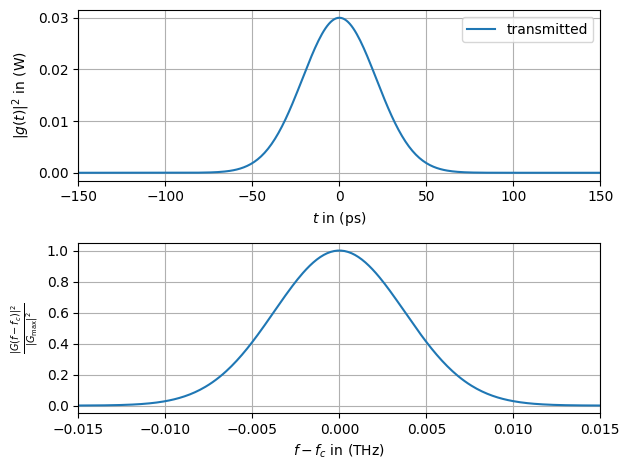

In [4]:
fig, (ax1, ax2) = plt.subplots(2, 1)

ax1.plot(t.numpy().flatten(), np.abs(g_0.numpy().flatten())**2, '-')
ax1.set_xlim(-150, 150)
ax1.set_xlabel(r"$t$ in (ps)")
ax1.set_ylabel(r"$|g(t)|^2$ in (W)")
ax1.grid()

ax2.plot(
    f.numpy().flatten(),
    (G_0.numpy().flatten())/np.max(G_0.numpy().flatten()),
    '-')
ax2.set_xlim(-0.015, 0.015)
ax2.set_xlabel(r"$f-f_c$ in (THz)")
ax2.set_ylabel(r"$\frac{|G(f-f_c)|^2}{|G_\mathrm{max}|^2}$")
ax2.grid()

ax1.legend(['transmitted'])
plt.tight_layout()
plt.show()

## Attenuation

Attenuation is present in all media including optical fibers. A typical value
of $\alpha=0.046\,\mathrm{km}^{-1}$ is used in this notebook.
To compensate for this, Erbium doped fiber amplifiers (EDFAs) are required, as shown in
the figure at the beginning of this notebook.

## Amplified Spontaneous Emission Noise

An optical channel model contains several sources of noise, e.g., amplified spontaneous
emission (ASE) and Rayleigh scattering. However, for this experiment, only ASE
noise is implemented. It was shown in [1] that this is the most dominant source of noise.

As we assume a discrete lumped amplification, ASE noise is introduced only due to the amplification by
the EDFAs. The noise power is given as

$$P_\mathrm{ASE}=\rho_\mathrm{ASE}\cdot f_\text{sim}=\frac{1}{2}G F h f_\text{c}\cdot f_\mathrm{sim}$$

and, hence, depends on the gain $G$, the (linear) noise figure $F$, the carrier frequency $f_\text{c}$,
and the simulation bandwidth $f_\mathrm{sim}$. The intermediate quantitiy $\rho_\mathrm{ASE}$ denotes the noise
spectral density of the EDFAs and $h$ is Planck's constant. Usually, not the simulation bandwidth but the captured
bandwidth $W$ of the receiver is used. Here, for demonstration purpose, our receiver has an infinite
bandwidth that is only limited by the simulation $W=f_\mathrm{sim}$.

**Note** that Sionna also provides ideally distributed Raman amplification, where the noise is introduced in
a fiber span. This can be enabled by setting `with_amplification` to `True` when instantiating the `SSFM` layer.

### Channel Configuration

The fiber (i.e., *SSFM*) is implemented using normalized units for distance and time.
Hence, it is required that the units of the same kind (time, distance, power) for all
parameters ($\alpha$, $\beta_2$, ...) have to be given with the same unit prefix,
e.g., for time use always $\mathrm{ps}$. This does not only simplify the usage of the SSFM but also prevents from dealing with different
orders of magnitude within the SSFM.

For our first experiment only ASE noise is considered and, thus, nonlinearity and chromatic dispersion (CD) are disabled.
Attenuation is kept enabled such that the amplifiers are required and introduce the noise.
The gain is chosen such that the link becomes transparent (input power equals output power).

In [5]:
# Normalization
t_norm = 1e-12  # (s) -> (ps) Time normalization
z_norm = 1e3  # (m) -> (km) Distance normalization

# Fiber parameters
f_c = 193.55e12  # (Hz) Abs. Carrier frequency
length_sp = 80.0  # (km) Norm. fiber span length
alpha = 0.046  # (1/km) Norm. fiber attenuation

# EDFA parameters
g_edfa = tf.exp(alpha * length_sp)
f_edfa = 10**(5/10)  # (1) Noise figure

In [6]:
span = sionna.phy.channel.optical.SSFM(
            alpha=alpha,
            f_c=f_c,
            length=length_sp,
            sample_duration=dt,
            with_amplification=False,
            with_attenuation=True,
            with_dispersion=False,
            with_nonlinearity=False,
            t_norm=t_norm)

amplifier = sionna.phy.channel.optical.EDFA(
             g=g_edfa,
             f=f_edfa,
             f_c=f_c,
             dt=dt * t_norm  # t_norm is in absolute (not normalized) units
            )

def lumped_amplification_channel(inputs):
    (u_0) = inputs

    u = u_0
    for _ in range(n_span):
        u = span(u)
        u = amplifier(u)

    return u

### Transmission

Next, the impulse is transmitted over the channel and the output is visualized.

In [7]:
x = g_0
y = lumped_amplification_channel(x)

X = tf.signal.fftshift(
    tf.abs(
        tf.cast(dt, config.tf_cdtype) *
        tf.signal.fft(x) /
        tf.cast(tf.math.sqrt(2 * np.pi), config.tf_cdtype)
    ) ** 2
)

Y = tf.signal.fftshift(
    tf.abs(
        tf.cast(dt, config.tf_cdtype) *
        tf.signal.fft(y) /
        tf.cast(tf.math.sqrt(2 * np.pi), config.tf_cdtype)
    ) ** 2
)

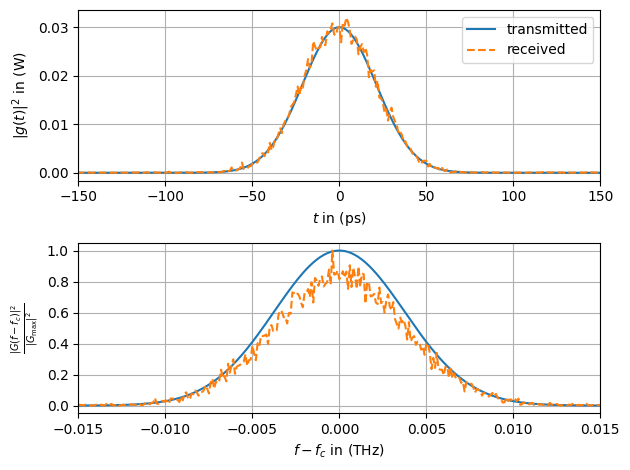

In [8]:
fig, (ax1, ax2) = plt.subplots(2, 1)

ax1.plot(t.numpy().flatten(), np.abs(x.numpy().flatten())**2, '-')
ax1.plot(t.numpy().flatten(), np.abs(y.numpy().flatten())**2, '--')
ax1.set_xlim(-150, 150)
ax1.set_xlabel(r"$t$ in (ps)")
ax1.set_ylabel(r"$|g(t)|^2$ in (W)")
ax1.grid()

ax2.plot(
    f.numpy().flatten(),
    (X.numpy().flatten())/np.max(X.numpy().flatten()),
    '-')
ax2.plot(
    f.numpy().flatten(),
    (Y.numpy().flatten())/np.max(Y.numpy().flatten()),
    '--')
ax2.set_xlim(-0.015, 0.015)
ax2.set_xlabel(r"$f-f_c$ in (THz)")
ax2.set_ylabel(r"$\frac{|G(f-f_c)|^2}{|G_\mathrm{max}|^2}$")
ax2.grid()

ax1.legend(['transmitted', 'received'])
plt.tight_layout()

plt.show()

As can be seen, attenuation is completely compensated by the EDFAs. However, they introduce significant noise.


## Chromatic Dispersion

After having seen how the noise distorts the original Gaussian impulse, we can now
enable the next linear effect, which is chromatic dispersion (CD). Regarding the nonlinear Schrödinger
equation that describes the propagation of an optical signal, the impact of CD is parametrized
by the group velocity dispersion (GVD) parameter $\beta_2$, where $\beta_2=-21.67\,\mathrm{ps}^2\mathrm{km}^{-1}$ is a typical choice.

### Channel Configuration

Besides the present parameters we now set $\beta_2$. For a better understanding of
CD we disable the noise (`EDFA.f = 0`) from the previous section.

In [9]:
beta_2 = -21.67  # (ps^2/km) Norm. group velocity dispersion

In [10]:
span_cd = sionna.phy.channel.optical.SSFM(
            alpha=alpha,
            beta_2=beta_2,
            f_c=f_c,
            length=length_sp,
            sample_duration=dt,
            with_amplification=False,
            with_attenuation=True,
            with_dispersion=True,
            with_nonlinearity=False,
            t_norm=t_norm)

amplifier_cd = sionna.phy.channel.optical.EDFA(
                                    g=g_edfa,
                                    f=0,
                                    f_c=f_c,
                                    dt=dt * t_norm)


def lumped_amplification_channel_cd(inputs):
    (u_0) = inputs

    u = u_0
    for _ in range(n_span):
        u = span_cd(u)
        u = amplifier_cd(u)

    return u

### Transmission

We now transmit the previously generated Gaussian impulse over the optical fiber and compare the received signal with the transmitted impulse.


In [11]:
x = g_0  # previously generated Gaussian impulse
y = lumped_amplification_channel_cd(x)

X = tf.signal.fftshift(
    tf.abs(
        tf.cast(dt, config.tf_cdtype) *
        tf.signal.fft(x) /
        tf.cast(tf.math.sqrt(2 * np.pi), config.tf_cdtype)
    ) ** 2
)

Y = tf.signal.fftshift(
    tf.abs(
        tf.cast(dt, config.tf_cdtype) *
        tf.signal.fft(y) /
        tf.cast(tf.math.sqrt(2 * np.pi), config.tf_cdtype)
    ) ** 2
)

X_angle = tf.math.angle(tf.signal.fftshift(tf.signal.fft(x)))
Y_angle = tf.math.angle(tf.signal.fftshift(tf.signal.fft(y)))

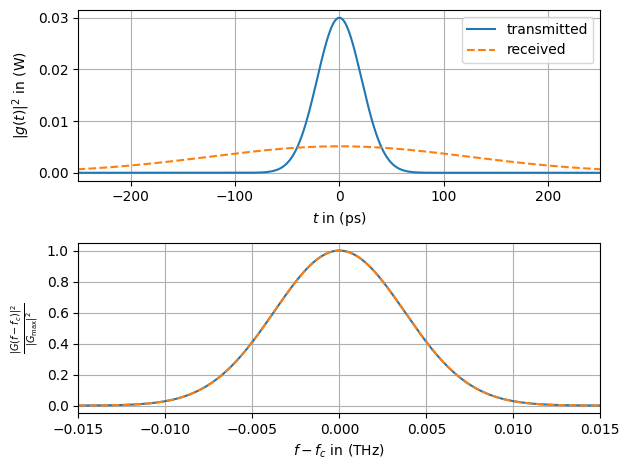

In [12]:
fig, (ax1, ax2) = plt.subplots(2, 1)

ax1.plot(t.numpy().flatten(), np.abs(x.numpy().flatten())**2, '-')
ax1.plot(t.numpy().flatten(), np.abs(y.numpy().flatten())**2, '--')
ax1.set_xlim(-250, 250)
ax1.set_xlabel(r"$t$ in (ps)")
ax1.set_ylabel(r"$|g(t)|^2$ in (W)")
ax1.grid()

ax2.plot(
    f.numpy().flatten(),
    (X.numpy().flatten())/np.max(X.numpy().flatten()),
    '-')
ax2.plot(
    f.numpy().flatten(),
    (Y.numpy().flatten())/np.max(Y.numpy().flatten()),
    '--')
ax2.set_xlim(-0.015, 0.015)
ax2.set_xlabel(r"$f-f_c$ in (THz)")
ax2.set_ylabel(r"$\frac{|G(f-f_c)|^2}{|G_\mathrm{max}|^2}$")
ax2.grid()

ax1.legend(['transmitted', 'received'])
plt.tight_layout()

plt.show()

Compared to the transmit impulse the received one has significantly broadened in time.
The absolute value of the spectrum, nevertheless, stayed the same.
By plotting the phase of the received signal one can see the typical parabolic shift.

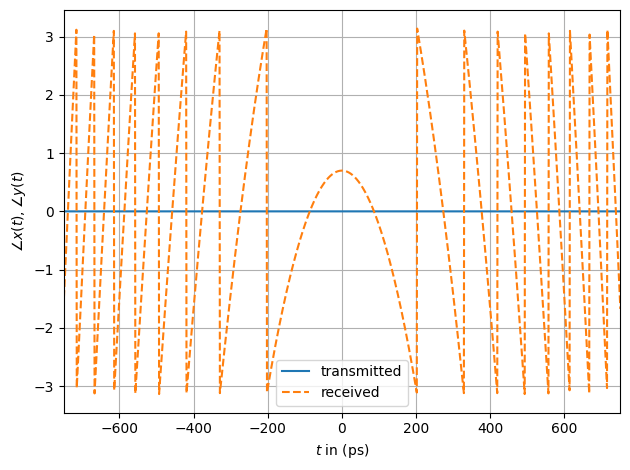

In [13]:
fig, (ax1) = plt.subplots(1, 1, tight_layout=True)

ax1.plot(t.numpy().flatten(), np.angle(x.numpy().flatten()), '-')
ax1.plot(t.numpy().flatten(), np.angle(y.numpy().flatten()), '--')
ax1.set_xlim(-750, 750)
ax1.set_xlabel(r"$t$ in (ps)")
ax1.set_ylabel("$\u2220 x(t), \u2220 y(t)$")
ax1.grid()

ax1.legend(['transmitted', 'received'])
plt.tight_layout()

plt.show()

## Kerr Nonlinearity

Last, we depict the Kerr nonlinearity and, for a better understanding, disable all previous impairments.
This nonlinear effect applies a phase shift to the transmitted signal depending on its
instantaneous power. Hence, we should see a phase that, in contrast to the phase of the original signal which is zero, follows the (inverse) absolute value of the impulse.

**Note:** Only the interaction between Kerr nonlinearity and CD requires an
SSFM for fiber simulation. Otherwise (as done so far), the transfer function
of the individual effect is just a single multiplication (in time- or Fourier-domain,
respectively).

### Channel configuration

Similarly to the definition of CD, we specify a typical value for $\gamma=1.27\,\mathrm{\frac{1}{km W}}$.

In [14]:
gamma = 1.27  # (1/W/km) Nonlinearity coefficient

In [15]:
span_nl = sionna.phy.channel.optical.SSFM(
            alpha=alpha,
            beta_2=beta_2,
            f_c=f_c,
            length=length_sp,
            sample_duration=dt,
            with_amplification=False,
            with_attenuation=True,
            with_dispersion=False,
            with_nonlinearity=True,
            t_norm=t_norm)

amplifier_nl = sionna.phy.channel.optical.EDFA(
                                g=g_edfa,
                                f=0,
                                f_c=f_c,
                                dt=dt * t_norm)


def lumped_amplification_channel_nl(inputs):
    (u_0) = inputs

    u = u_0
    for _ in range(n_span):
        u = span_nl(u)
        u = amplifier_nl(u)

    return u

### Transmission

We now transmit the same Gaussian impulse again over the optical fiber where only Kerr nonlinearity is activated.


In [16]:
x = g_0
y = lumped_amplification_channel_nl(x)

X = tf.signal.fftshift(
    tf.abs(
        tf.cast(dt, config.tf_cdtype) *
        tf.signal.fft(x) /
        tf.cast(tf.math.sqrt(2 * np.pi), config.tf_cdtype)
    ) ** 2
)

Y = tf.signal.fftshift(
    tf.abs(
        tf.cast(dt, config.tf_cdtype) *
        tf.signal.fft(y) /
        tf.cast(tf.math.sqrt(2 * np.pi), config.tf_cdtype)
    ) ** 2
)

X_angle = tf.math.angle(tf.signal.fftshift(tf.signal.fft(x)))
Y_angle = tf.math.angle(tf.signal.fftshift(tf.signal.fft(y)))

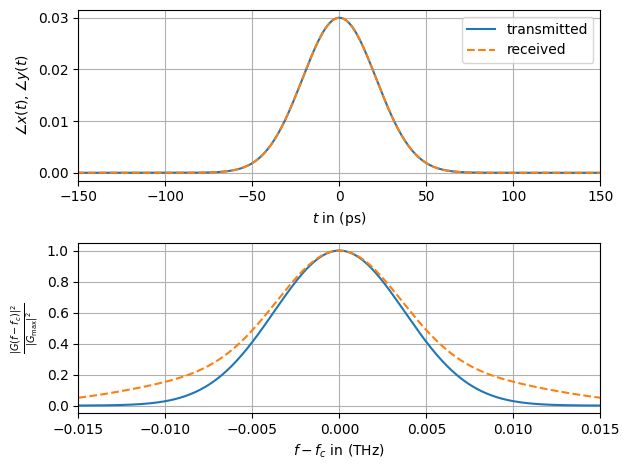

In [17]:
fig, (ax1, ax2) = plt.subplots(2, 1)

ax1.plot(t.numpy().flatten(), np.abs(x.numpy().flatten())**2, '-')
ax1.plot(t.numpy().flatten(), np.abs(y.numpy().flatten())**2, '--')
ax1.set_xlim(-150, 150)
ax1.set_xlabel(r"$t$ in (ps)")
ax1.set_ylabel("$\u2220 x(t), \u2220 y(t)$")
ax1.grid()

ax2.plot(
    f.numpy().flatten(),
    (X.numpy().flatten())/np.max(X.numpy().flatten()),
    '-')
ax2.plot(
    f.numpy().flatten(),
    (Y.numpy().flatten())/np.max(Y.numpy().flatten()),
    '--')
ax2.set_xlim(-0.015, 0.015)
ax2.set_xlabel(r"$f-f_c$ in (THz)")
ax2.set_ylabel(r"$\frac{|G(f-f_c)|^2}{|G_\mathrm{max}|^2}$")
ax2.grid()

ax1.legend(['transmitted', 'received'])
plt.tight_layout()


plt.show()

As shown in the previous plot the (isolated) Kerr nonlinearity does not affect the
absolute value of the signal's amplitude but only shifts the phase (see below).

Further, the bandwidth of the transmit signal was slightly increased.

**Hint**: Increasing the peak power $p_0$ of the transmitted impuls increases the impact of the Kerr nonlinearity.


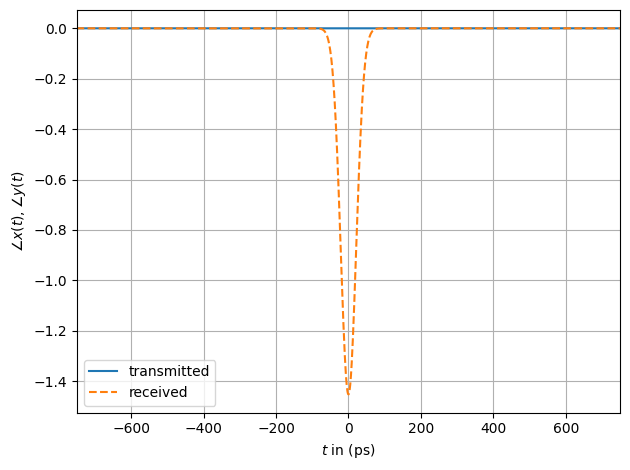

In [18]:
fig, (ax1) = plt.subplots(1, 1, tight_layout=True)

ax1.plot(t.numpy().flatten(), np.angle(x.numpy().flatten()), '-')
ax1.plot(t.numpy().flatten(), np.angle(y.numpy().flatten()), '--')
ax1.set_xlim(-750, 750)
ax1.set_xlabel("$t$ in (ps)")
ax1.set_ylabel("$\u2220 x(t), \u2220 y(t)$")
ax1.grid()

ax1.legend(['transmitted', 'received'])
plt.tight_layout()

plt.show()

## Split-Step Fourier Method

Last, we perform the true SSFM to simulate the impairments (ASE noise, CD, and Kerr
nonlinearity) jointly. As this is computationally complex, we compile
the channel model before its execution by adding the `tf.function` decorator.

### Channel Configuration

Keeping the former configuration, we only have to increase the number of SSFM simulation steps.

In [19]:
n_ssfm = 160  # number of SSFM simulation steps

In [20]:
span_ssfm = sionna.phy.channel.optical.SSFM(
            alpha=alpha,
            beta_2=beta_2,
            gamma=gamma,
            f_c=f_c,
            length=length_sp,
            sample_duration=dt,
            n_ssfm=n_ssfm,
            with_amplification=False,
            with_attenuation=True,
            with_dispersion=True,
            with_nonlinearity=True,
            t_norm=t_norm)

amplifier_ssfm = sionna.phy.channel.optical.EDFA(
                        g=g_edfa,
                        f=0,
                        f_c=f_c,
                        dt=dt * t_norm)

@tf.function
def lumped_amplification_channel_ssfm(inputs):
    (u_0) = inputs

    u = u_0
    for _ in range(1):
        u = span_ssfm(u)
        u = amplifier_ssfm(u)

    return u

### Transmission

We transmit the Gaussian impulse over the optical fiber. However, we have now enabled ASE noise, CD, and Kerr
nonlinearity.

In [21]:
x = g_0
y = lumped_amplification_channel_ssfm(x)

X = tf.signal.fftshift(
    tf.abs(
        tf.cast(dt, config.tf_cdtype) *
        tf.signal.fft(x) /
        tf.cast(tf.math.sqrt(2 * np.pi), config.tf_cdtype)
    ) ** 2
)

Y = tf.signal.fftshift(
    tf.abs(
        tf.cast(dt, config.tf_cdtype) *
        tf.signal.fft(y) /
        tf.cast(tf.math.sqrt(2 * np.pi), config.tf_cdtype)
    ) ** 2
)

X_angle = tf.math.angle(tf.signal.fftshift(tf.signal.fft(x)))
Y_angle = tf.math.angle(tf.signal.fftshift(tf.signal.fft(y)))

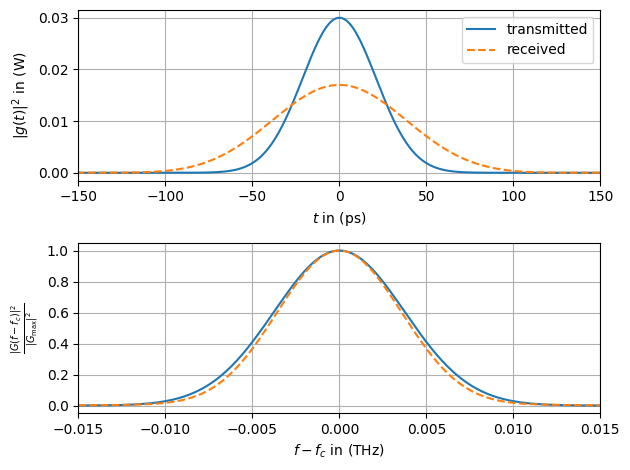

In [22]:
fig, (ax1, ax2) = plt.subplots(2, 1)

ax1.plot(t.numpy().flatten(), np.abs(x.numpy().flatten())**2, '-')
ax1.plot(t.numpy().flatten(), np.abs(y.numpy().flatten())**2, '--')
ax1.set_xlim(-150, 150)
ax1.set_xlabel(r"$t$ in (ps)")
ax1.set_ylabel(r"$|g(t)|^2$ in (W)")
ax1.grid()

ax2.plot(
    f.numpy().flatten(),
    (X.numpy().flatten()/np.max(X.numpy().flatten())),
    '-')
ax2.plot(
    f.numpy().flatten(),
    (Y.numpy().flatten()/np.max(Y.numpy().flatten())),
    '--')
ax2.set_xlim(-0.015, 0.015)
ax2.set_xlabel(r"$f-f_c$ in (THz)")
ax2.set_ylabel(r"$\frac{|G(f-f_c)|^2}{|G_\mathrm{max}|^2}$")
ax2.grid()

ax1.legend(['transmitted', 'received'])
plt.tight_layout()

plt.show()

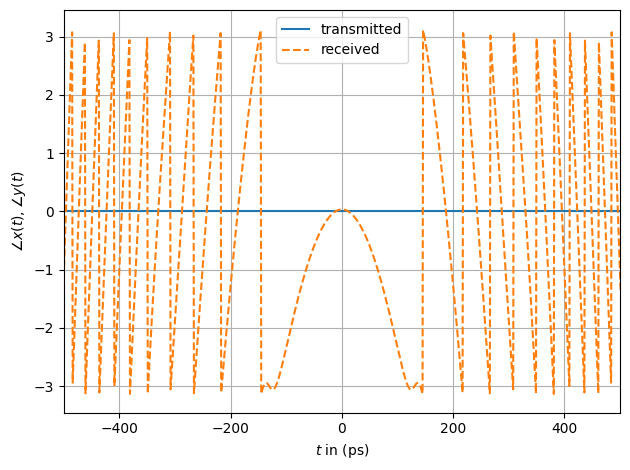

In [23]:
fig, (ax1) = plt.subplots(1, 1, tight_layout=True)

ax1.plot(t.numpy().flatten(), np.angle(x.numpy().flatten()), '-')
ax1.plot(t.numpy().flatten(), np.angle(y.numpy().flatten()), '--')
ax1.set_xlim(-500, 500)
ax1.set_xlabel("$t$ in (ps)")
ax1.set_ylabel("$\u2220 x(t), \u2220 y(t)$")
ax1.grid()

ax1.legend(['transmitted', 'received'])
plt.tight_layout()

plt.show()

The most interesting observation that one can make here is that the
spectrum of the received signal is compressed. This is in contrast
to the expected Kerr nonlinearity-induced spectral broadening, and shows
that joint application of the fiber effects may result in completely
different observations compared to the isolated investigation.

What we can see here, however, is that the Gaussian input impulse is
transformed to a higher-order Soliton during propagation. Those require
a joint CD and Kerr nonlinearity to exist.


## References

[1] René-Jean Essiambre, Gerhard Kramer, Peter J. Winzer, Gerard J. Foschini, and Bernhard Goebel.
„Capacity Limits of Optical Fiber Networks“. Journal of Lightwave Technology 28, Nr. 4, pp 662–701, February 2010.


